# Classificação de Caracteres Árabes Manuscritos com PyTorch

## Informações do Grupo

- **Nome(s) do(s) Integrante(s):** Richardson Allan Ferreira de Souza
- **Email(s):** rafs2@cesar.school
- **Link para o Dataset Escolhido:** [Arabic Handwritten Characters Dataset](https://www.kaggle.com/datasets/mloey1/ahcd1)

Este notebook tem como objetivo treinar uma rede neural para classificar caracteres árabes manuscritos.

## 1. Carregamento do Dataset e Manipulações

Primeiro, vamos importar as bibliotecas necessárias e preparar o dataset.

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
zip_path = "./data/ahcd1.zip"
if not os.path.exists(zip_path):
    print(f"Arquivo '{zip_path}' não encontrado. Baixando do Kaggle...")
    !curl -L -o ./data/ahcd1.zip https://www.kaggle.com/api/v1/datasets/download/mloey1/ahcd1
else:
    print(f"Arquivo '{zip_path}' já existe.")

Arquivo './data/ahcd1.zip' já existe.


In [3]:
if not os.path.exists(zip_path):
    extraction_path = "./data/"
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"Arquivo '{zip_path}' extraído para '{extraction_path}'.")

In [4]:
train_image = pd.read_csv("./data/csvTrainImages 13440x1024.csv", header = None)
train_label = pd.read_csv("./data/csvTrainLabel 13440x1.csv", header = None)
test_image = pd.read_csv("./data/csvTestImages 3360x1024.csv", header = None )
test_label = pd.read_csv("./data/csvTestLabel 3360x1.csv", header = None )

In [5]:
train_image['label'] = train_label
test_image['label'] = test_label

print(train_image.shape)

(13440, 1025)


### Transformações e DataLoaders

In [6]:
IMAGE_SIZE = 32     # As imagens do dataset AHCD são tipicamente 32x32
NUM_CLASS = 28    # Alfabeto árabe tem 28 letras básicas

In [7]:
class ImageDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data.iloc[index, self.data.columns != 'label'].values.astype(np.uint8).reshape(IMAGE_SIZE, IMAGE_SIZE)
        label = self.data.iloc[index, -1] - 1

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [17]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_image_dataset = ImageDataset(train_image, transform)
test_image_dataset = ImageDataset(test_image, transform)

In [9]:
print(f"Dataset de treino carregado: {len(train_image_dataset)} amostras.")
print(f"Dataset de teste carregado: {len(test_image_dataset)} amostras.")

Dataset de treino carregado: 13440 amostras.
Dataset de teste carregado: 3360 amostras.


In [10]:
image , label = train_image_dataset.__getitem__(32)
image.size()

torch.Size([1, 32, 32])

In [11]:
try:
    available_cores = os.cpu_count()
    num_workers_to_use = min(max(1, available_cores // 2 if available_cores else 1), 8)
    use_cuda = torch.cuda.is_available()
    train_kwargs = {'batch_size': 64}
    test_kwargs = {'batch_size': 1000}
    if use_cuda:
        cuda_kwargs = {
            'pin_memory': True,
            'shuffle': True
        }
        cuda_kwargs['num_workers'] = num_workers_to_use
        print(f"Using {cuda_kwargs['num_workers']} workers for CUDA data loading.")
        train_kwargs.update(cuda_kwargs)
        test_kwargs_no_shuffle = cuda_kwargs.copy()
        test_kwargs_no_shuffle['shuffle'] = False # Não embaralhar o test loader para análise consistente
        test_kwargs.update(test_kwargs_no_shuffle)
    else:
        train_kwargs['shuffle'] = True
        test_kwargs['shuffle'] = False

    train_loader = DataLoader(train_image_dataset, **train_kwargs)
    test_loader = DataLoader(test_image_dataset, **test_kwargs)
    print("DataLoaders criados com sucesso.")

except Exception as e:
    print(f"Erro ao carregar dataset com ImageFolder: {e}")
    print("Verifique se os diretórios train_image_dataset e test_image_dataset estão corretos e ")
    print("contêm subdiretórios para cada classe de caractere árabe.")
    train_loader = None # Para evitar erros subsequentes se o carregamento falhar
    test_loader = None

Using 4 workers for CUDA data loading.
DataLoaders criados com sucesso.


## 2. Definição do Modelo de Redes Neurais

Vamos definir uma rede neural convolucional (CNN) similar à do notebook MNIST, mas ajustada para o dataset de caracteres árabes (número de classes e, potencialmente, tamanho da camada linear devido ao tamanho da imagem de entrada).

In [12]:
class Net(nn.Module):
    def __init__(self, num_classes=28):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1_input_features = 64 * (IMAGE_SIZE // 2) * (IMAGE_SIZE // 2) 
        self.fc1 = nn.Linear(self.fc1_input_features, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

# Verificar se o CUDA está disponível e definir o dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

model = Net(num_classes=NUM_CLASS).to(device)

Usando dispositivo: cuda


## 3. Treinamento do Modelo

In [13]:
def train(log_interval, dry_run, model, device, train_loader, optimizer, epoch, losses_list, accuracies_list):
    model.train()
    correct_epoch = 0
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * data.size(0)
        pred = output.argmax(dim=1, keepdim=True)
        correct_epoch += pred.eq(target.view_as(pred)).sum().item()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if dry_run:
                break
    
    avg_epoch_loss = epoch_loss / len(train_loader.dataset)
    epoch_accuracy = 100. * correct_epoch / len(train_loader.dataset)
    losses_list.append(avg_epoch_loss)
    accuracies_list.append(epoch_accuracy)
    print(f'Epoch {epoch} - Fim do Treino: Perda Média: {avg_epoch_loss:.4f}, Acurácia: {correct_epoch}/{len(train_loader.dataset)} ({epoch_accuracy:.2f}%)')

def test(model, device, test_loader, losses_list, accuracies_list, all_preds_list, all_targets_list):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            all_preds_list.extend(pred.view(-1).cpu().numpy())
            all_targets_list.extend(target.view(-1).cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    losses_list.append(test_loss)
    accuracies_list.append(accuracy)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))
    return test_loss, accuracy

In [14]:
if train_loader and test_loader:
    torch.manual_seed(1111)

    model = Net(num_classes=NUM_CLASS).to(device) # Reinicializar modelo para garantir
    optimizer = optim.Adadelta(model.parameters(), lr=1.0, weight_decay=1e-5) # lr=1.0 como no exemplo MNIST

    epochs = 32 # Ajuste o número de épocas conforme necessário
    gamma = 0.7 # Fator de decaimento do learning rate
    log_interval = 10 # A cada quantos batches imprimir o log
    dry_run = False # Defina como True para um teste rápido com um batch por época

    scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

    train_losses_hist = []
    train_accuracies_hist = []
    test_losses_hist = []
    test_accuracies_hist = []
    
    all_predictions = []
    all_true_labels = []

    for epoch in range(1, epochs + 1):
        train(log_interval, dry_run, model, device, train_loader, optimizer, epoch, train_losses_hist, train_accuracies_hist)
        current_test_loss, current_test_accuracy = test(model, device, test_loader, test_losses_hist, test_accuracies_hist, all_predictions if epoch == epochs else [], all_true_labels if epoch == epochs else [])
        scheduler.step()
        if dry_run and epoch ==1: # Se dry_run, fazer só uma época completa e sair
            print("Dry run concluído após 1 época.")
            break
else:
    print("DataLoaders não foram inicializados. Verifique os passos de carregamento do dataset.")

Train Epoch: 1 [0/13440 (0%)]	Loss: 3.341548
Train Epoch: 1 [640/13440 (5%)]	Loss: 3.120229
Train Epoch: 1 [1280/13440 (10%)]	Loss: 3.079884
Train Epoch: 1 [1920/13440 (14%)]	Loss: 2.748098
Train Epoch: 1 [2560/13440 (19%)]	Loss: 2.749009
Train Epoch: 1 [3200/13440 (24%)]	Loss: 2.427903
Train Epoch: 1 [3840/13440 (29%)]	Loss: 2.276865
Train Epoch: 1 [4480/13440 (33%)]	Loss: 2.003794
Train Epoch: 1 [5120/13440 (38%)]	Loss: 1.780030
Train Epoch: 1 [5760/13440 (43%)]	Loss: 1.852584
Train Epoch: 1 [6400/13440 (48%)]	Loss: 1.791835
Train Epoch: 1 [7040/13440 (52%)]	Loss: 1.541234
Train Epoch: 1 [7680/13440 (57%)]	Loss: 1.890952
Train Epoch: 1 [8320/13440 (62%)]	Loss: 1.735860
Train Epoch: 1 [8960/13440 (67%)]	Loss: 1.675639
Train Epoch: 1 [9600/13440 (71%)]	Loss: 1.512564
Train Epoch: 1 [10240/13440 (76%)]	Loss: 1.816230
Train Epoch: 1 [10880/13440 (81%)]	Loss: 1.249320
Train Epoch: 1 [11520/13440 (86%)]	Loss: 1.549172
Train Epoch: 1 [12160/13440 (90%)]	Loss: 1.404105
Train Epoch: 1 [12800/

## 4. Análise Simples da Performance

Vamos visualizar a perda (loss) e a acurácia ao longo das épocas. Também podemos gerar uma matriz de confusão para uma análise mais detalhada dos erros de classificação.

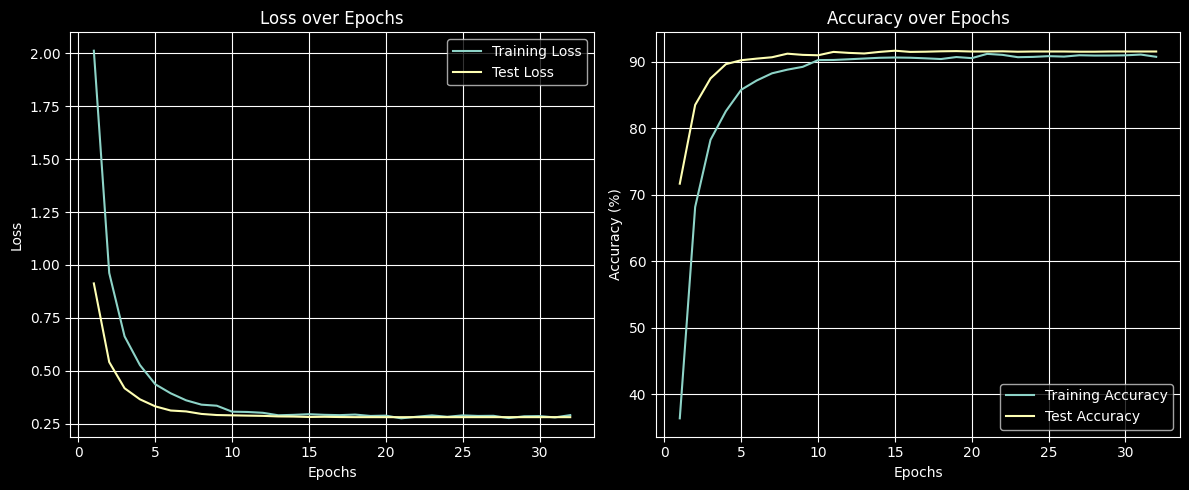

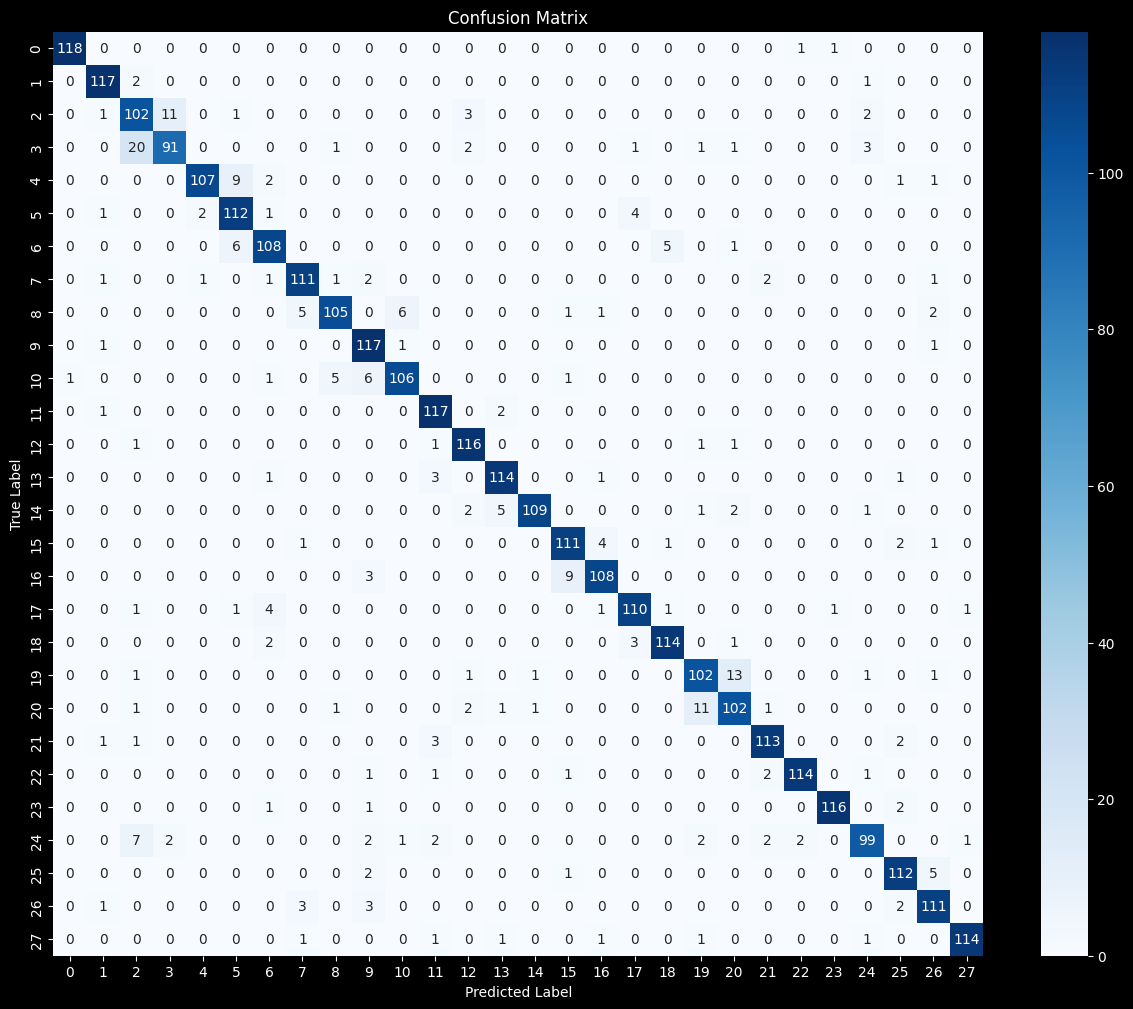

In [15]:
if train_loader and test_loader and not dry_run: # Plotar apenas se o treino completo ocorreu
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_losses_hist, label='Training Loss')
    plt.plot(range(1, epochs + 1), test_losses_hist, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_accuracies_hist, label='Training Accuracy')
    plt.plot(range(1, epochs + 1), test_accuracies_hist, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy over Epochs')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Matriz de Confusão
    # Recalcular previsões no conjunto de teste se não foram coletadas na última época do treino
    if not all_predictions or not all_true_labels:
        print("Coletando predições finais para a matriz de confusão...")
        all_predictions_final = []
        all_true_labels_final = []
        model.eval()
        with torch.no_grad():
            for data, target in test_loader: # Use o test_loader original, não o dos kwargs
                data, target = data.to(device), target.to(device)
                output = model(data)
                pred = output.argmax(dim=1, keepdim=True)
                all_predictions_final.extend(pred.view(-1).cpu().numpy())
                all_true_labels_final.extend(target.view(-1).cpu().numpy())
    else:
        all_predictions_final = all_predictions
        all_true_labels_final = all_true_labels
        
    if all_predictions_final and all_true_labels_final:
        cm = confusion_matrix(all_true_labels_final, all_predictions_final, labels=list(range(NUM_CLASS)))
        plt.figure(figsize=(15, 12))
        # As classes são nomeadas de 0 a 27.
        # Ou use train_image_dataset.classes para obter os nomes das classes se disponíveis.
        class_names = [str(i) for i in range(NUM_CLASS)]
        try:
            if hasattr(train_image_dataset, 'classes') and len(train_image_dataset.classes) == NUM_CLASS:
                 class_names = train_image_dataset.classes
        except NameError:
            pass # Mantém os nomes numéricos se train_image_dataset não estiver definido
            
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    else:
        print("Não foi possível gerar a matriz de confusão. Predições ou rótulos verdadeiros estão faltando.")

elif dry_run:
    print("Gráficos e matriz de confusão não gerados devido ao dry_run.")
else:
    print("Treinamento não executado ou falhou. Gráficos e matriz de confusão não podem ser gerados.")

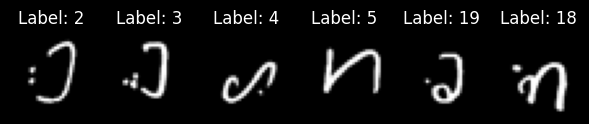

In [16]:
indices_2 = [i for i, label in enumerate(all_true_labels_final) if label == 2]
indices_3 = [i for i, label in enumerate(all_true_labels_final) if label == 3]
indices_4 = [i for i, label in enumerate(all_true_labels_final) if label == 4]
indices_5 = [i for i, label in enumerate(all_true_labels_final) if label == 5]
indices_19 = [i for i, label in enumerate(all_true_labels_final) if label == 19]
indices_18 = [i for i, label in enumerate(all_true_labels_final) if label == 18]

# Selecionar o primeiro exemplo de cada classe
idx_2 = indices_2[0] if indices_2 else None
idx_3 = indices_3[0] if indices_3 else None
idx_4 = indices_4[0] if indices_4 else None
idx_5 = indices_5[0] if indices_5 else None
idx_19 = indices_19[0] if indices_19 else None
idx_18 = indices_18[0] if indices_18 else None

fig, axs = plt.subplots(1, 6, figsize=(6, 3))
for ax, idx, label_num in zip(axs, [idx_2, idx_3, idx_4, idx_5, idx_19, idx_18], [2, 3, 4, 5, 19, 18]):
    if idx is not None:
        # Recuperar a imagem original do DataFrame test_image
        img_flat = test_image.iloc[idx, :-1].values.astype(np.uint8)
        img = img_flat.reshape(IMAGE_SIZE, IMAGE_SIZE)
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {label_num}')
        ax.axis('off')
    else:
        ax.set_visible(False)
plt.tight_layout()
plt.show()

## 5. Experiência e Dificuldades

O processo de desenvolvimento do modelo de classificação de caracteres árabes manuscritos foi bastante enriquecedor. Inicialmente, enfrentei desafios no carregamento e pré-processamento dos dados, já que o dataset estava em formato CSV e exigiu a criação de uma classe customizada de Dataset para uso com o PyTorch. Após a preparação dos dados, adaptei uma arquitetura de CNN inspirada no exemplo do MNIST do notebook 4.6-MNIST_neuralnet.ipynb, ajustando o número de classes e o tamanho das camadas para as imagens 32x32. Durante o treinamento, observei uma boa evolução da acurácia tanto no treino quanto no teste, sem sinais evidentes de overfitting, o que indica que as estratégias de regularização e normalização foram eficazes. A análise dos gráficos de perda e acurácia, além da matriz de confusão, ajudou a identificar classes mais difíceis. No geral, a experiência reforçou a importância do pré-processamento e da experimentação iterativa para alcançar bons resultados em tarefas de visão computacional.
